In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import utils

random_wav = "bass_electronic_018-022-100.wav"


audio = utils.load_audio(random_wav)
sample_length = audio.shape[0]
print(sample_length)
audio = np.concatenate((audio, audio))
 

64000


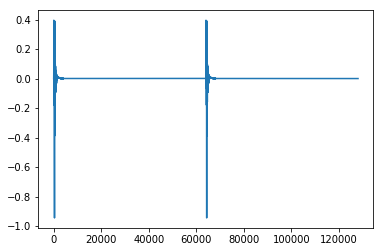

In [3]:
%matplotlib inline
plt.plot(audio)
plt.show()

In [4]:
print(audio)

[  0.00000000e+00   6.10351562e-05   2.13623047e-04 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


In [6]:
def mul_or_none(a, b):
  """Return the element wise multiplicative of the inputs.

  If either input is None, we return None.

  Args:
    a: A tensor input.
    b: Another tensor input with the same type as a.

  Returns:
    None if either input is None. Otherwise returns a * b.
  """
  if a is None or b is None:
    return None
  return a * b

def time_to_batch(x, block_size):
  """Splits time dimension (i.e. dimension 1) of `x` into batches.

  Within each batch element, the `k*block_size` time steps are transposed,
  so that the `k` time steps in each output batch element are offset by
  `block_size` from each other.

  The number of input time steps must be a multiple of `block_size`.

  Args:
    x: Tensor of shape [nb, k*block_size, n] for some natural number k.
    block_size: number of time steps (i.e. size of dimension 1) in the output
      tensor.

  Returns:
    Tensor of shape [nb*block_size, k, n]
  """
  shape = x.get_shape().as_list()
  y = tf.reshape(x, [
      shape[0], shape[1] // block_size, block_size, shape[2]
  ])
  y = tf.transpose(y, [0, 2, 1, 3])
  y = tf.reshape(y, [
      shape[0] * block_size, shape[1] // block_size, shape[2]
  ])
  y.set_shape([
      mul_or_none(shape[0], block_size), mul_or_none(shape[1], 1. / block_size),
      shape[2]
  ])
  return y


def batch_to_time(x, block_size):
  """Inverse of `time_to_batch(x, block_size)`.

  Args:
    x: Tensor of shape [nb*block_size, k, n] for some natural number k.
    block_size: number of time steps (i.e. size of dimension 1) in the output
      tensor.

  Returns:
    Tensor of shape [nb, k*block_size, n].
  """
  shape = x.get_shape().as_list()
  y = tf.reshape(x, [shape[0] // block_size, block_size, shape[1], shape[2]])
  y = tf.transpose(y, [0, 2, 1, 3])
  y = tf.reshape(y, [shape[0] // block_size, shape[1] * block_size, shape[2]])
  y.set_shape([mul_or_none(shape[0], 1. / block_size),
               mul_or_none(shape[1], block_size),
               shape[2]])
  return y



In [1]:
import tensorflow as tf
learning_rate = 0.00001
num_lstm = 512
with tf.Graph().as_default():
    #session_config = tf.Config
    with tf.Session() as sess:
        lstm = tf.contrib.rnn.BasicLSTMCell(num_lstm)
        #initial_state = tf.zeros([batch_size, lstm.state_size])
        
#encode with 8 bit mu-law
x = audio
x_quantized = utils.mu_law(x)
x_scaled = tf.cast(x_quantized, tf.float32) / 128.0
#x_scaled = tf.expand_dims(x_scaled, 2)
num_z = 16
print(x_scaled)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


NameError: name 'audio' is not defined

In [40]:
num_layers = 1
num_steps = 1
input_size = 1
lstm_size = 128
keep_prob = 1
stock_count = 1
embed_size = 1

In [91]:
tf.reset_default_graph()

#official tutorial: words_in_dataset = tf.placeholder(tf.float32, [time_steps, batch_size, num_features])
learning_rate = tf.placeholder(tf.float32, None, name="learning_rate")
# symbols are mapped to integers.
symbols = tf.placeholder(tf.int32, [None, 1], name='symbols')
inputs = tf.placeholder(tf.float32, [None, num_steps, input_size], name="inputs")

#inputs = tf.reshape(inputs, tf.TensorShape([64000,1,1]))
targets = tf.placeholder(tf.float32, [None, input_size], name="targets")

def _create_one_cell():
    lstm_cell = tf.contrib.rnn.LSTMCell(lstm_size, state_is_tuple=True)
    '''
    if keep_prob < 1.0:
        lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)    '''
    return lstm_cell

cell = tf.contrib.rnn.MultiRNNCell([_create_one_cell() for _ in range(num_layers)],state_is_tuple=True
) if num_layers > 1 else _create_one_cell()


#embedding layer
embed_matrix = tf.Variable(
    tf.random_uniform([stock_count, embed_size], -1.0, 1.0),
    name="embed_matrix"
)
sym_embeds = tf.nn.embedding_lookup(embed_matrix, symbols)
            
# stock_label_embeds.shape = (batch_size, embedding_size)
stacked_symbols = tf.tile(symbols, [1, num_steps], name='stacked_stock_labels')
stacked_embeds = tf.nn.embedding_lookup(embed_matrix, stacked_symbols)

# After concat, inputs.shape = (batch_size, num_steps, lstm_size + embed_size)
inputs_with_embed = tf.concat([inputs, stacked_embeds], axis=2, name="inputs_with_embed")

val, state_ = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32, scope="dynamic_rnn")

# Before transpose, val.get_shape() = (batch_size, num_steps, lstm_size)
# After transpose, val.get_shape() = (num_steps, batch_size, lstm_size)
val = tf.transpose(val, [1, 0, 2])
last = tf.gather(val, int(val.get_shape()[0]) - 1, name="lstm_state")
ws = tf.Variable(tf.truncated_normal([lstm_size, input_size]), name="w")
bias = tf.Variable(tf.constant(0.1, shape=[input_size]), name="b")
pred = tf.matmul(last, ws) + bias

loss = tf.reduce_mean(tf.square(pred - targets), name="loss_mse")
optim = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, name="rmsprop_optim")

/home/keplerc/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [107]:
audio = utils.load_audio(random_wav)
audio = list(map(lambda x: x, audio))
np.array(audio)

import numpy as np
import pandas as pd
import random

#normalized does not work
class dt():
    def __init__(self, raw_audio, input_size = input_size, num_steps = num_steps, test_ratio = 0.1, normalized = False):
        self.raw_seq = np.array(raw_audio)
        self.input_size = input_size
        self.num_steps = num_steps 
        self.test_ratio = test_ratio
        self.normalized = normalized
        self.train_X, self.train_y, self.test_X, self.test_y = self._prepare_data(self.raw_seq)

    def _prepare_data(self, seq):
        # split into items of input_size
        seq = [np.array(seq[i * self.input_size: (i + 1) * self.input_size])
               for i in range(len(seq) // self.input_size)]
        
        if self.normalized:
            seq = [seq[0] / seq[0][0] - 1.0] + [
                curr / seq[i][-1] - 1.0 for i, curr in enumerate(seq[1:])]

        # split into groups of num_steps
        X = np.array([seq[i: i + self.num_steps] for i in range(len(seq) - self.num_steps)])
        y = np.array([seq[i + self.num_steps] for i in range(len(seq) - self.num_steps)])

        train_size = int(len(X) * (1.0 - self.test_ratio))
        train_X, test_X = X[:train_size], X[train_size:]
        train_y, test_y = y[:train_size], y[train_size:]
        return train_X, train_y, test_X, test_y

    def generate_one_epoch(self, batch_size):
        num_batches = int(len(self.train_X)) // batch_size
        if batch_size * num_batches < len(self.train_X):
            num_batches += 1

        batch_indices = list(range(num_batches))
        random.shuffle(batch_indices)
        for j in batch_indices:
            batch_X = self.train_X[j * batch_size: (j + 1) * batch_size]
            batch_y = self.train_y[j * batch_size: (j + 1) * batch_size]
            assert set(map(len, batch_X)) == {self.num_steps}
            yield batch_X, batch_y

In [108]:
batch_labels = np.ones([100,1])
batch_labels

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
      

In [112]:
batch_size = 100
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    merged_test_X = np.array(audio)
    merged_test_y = np.array(audio)

    global_step = 0
    epoch_step = 0
    d = dt(audio)
    for batch_x, batch_y in d.generate_one_epoch(batch_size):
        global_step += 1
        epoch_step += 1
        train_data_feed = {
            learning_rate : 0.00001,
            inputs: batch_x,
            targets: batch_y,
            symbols: batch_labels,
        }
        train_loss, _ = sess.run([loss, optim], train_data_feed)
        print(train_loss)

0.00999953
0.00999666
0.00999219
0.00998724
0.009985
0.00998053
0.00997603
0.00999644
0.00996763
0.00996277
0.0099574
0.00893784
0.00994626
0.0211907
0.00994362
0.00993945
0.00992828
0.00992072
0.20389
0.00988702
0.00987776
0.00986855
0.00985783
0.00984943
0.00983936
0.00982879
0.00981717
0.00980514
0.0174457
0.0097778
0.00976214
0.00975127
0.00973348
0.00971814
0.00970173
0.00972249
0.00966871
0.00965163
0.0150719
0.00960802
0.0095884
0.00956742
0.00954473
0.00952247
0.00949831
0.009474
0.00944837
0.00942309
0.00939853
0.00936782
0.00934076
0.00931082
0.00927909
0.00925154
0.00922064
0.00919056
0.00915393
0.00912217
0.00908788
0.00905298
0.00901794
0.0089807
0.00894455
0.00890856
0.00887191
0.00883323
0.00879512
0.00875661
0.0087181
0.00867806
0.00863848
0.00860111
0.0085596
0.00851877
0.00842772
0.00843762
0.00839411
0.00835392
0.00831275
0.0082715
0.0082285
0.0081876
0.00814522
0.00810377
0.00806061
0.00793197
0.0079766
0.00793411
0.00788791
0.00784889
0.00780701
0.00776405
0.007722